# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [29]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [30]:
#load csv into dataframe
df=pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [31]:
#get number of rows from shape
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [32]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [33]:
#filter dataframe on converted column before getting mean
df['converted'].mean() * 100

11.965919355605511

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [34]:
#find number of rows where group and page type are mismatched
len(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')])

1965

**f.** Do any of the rows have missing values?

In [35]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [36]:
#store mismatched groups & landings to be removed
mismatched_rows = df[((df['group'] == 'control') & (df['landing_page'] != 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))]

#remove mismatched rows for new data frame
df2 = df[~df.index.isin(mismatched_rows.index)]

#reset index for df2
df2.reset_index(drop=True, inplace=True)

In [37]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [38]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [39]:
#get rows with duplicate user_ids and store in duplicate_user
duplicate_user = df2[df2.duplicated(subset='user_id',keep=False)]
print(duplicate_user)

      user_id                   timestamp      group landing_page  converted
1876   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2862   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**c.** Display the rows for the duplicate **user_id**? 

In [40]:
print(duplicate_user)

      user_id                   timestamp      group landing_page  converted
1876   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2862   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [41]:
#drop duplicate rows based off duplicate user_id, keep first occurrence
df2 = df2.drop_duplicates(subset='user_id', keep='first')
#check for any remaining duplicates, output should be blank dataframe
df2[df2.duplicated(subset='user_id',keep=False)]


,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [42]:
#get conversion rate for all users
convert_p_pop = df2['converted'].mean()
print(convert_p_pop)

0.119597087245


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [43]:
#filter dataframe to control group and get conversion rate
control_group_df2 = df2[df2['group'] == 'control']
control_conversion = control_group_df2['converted'].mean()
print(control_conversion)

0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [44]:
#filter dataframe to treatment group and get conversion rate
treatment_group_df2 = df2[df2['group'] == 'treatment']
treatment_conversion = treatment_group_df2['converted'].mean()
print(treatment_conversion)

0.118808065515


>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [17]:
obs_diff =   treatment_conversion - control_conversion 
print(obs_diff)

-0.00157823898536


**d.** What is the probability that an individual received the new page?

In [18]:
#get probability of users that received new_page
new_page_prob = (df2['landing_page'] == 'new_page').mean()
print(new_page_prob)

0.500061944223


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

The data in parts A - D above do not indicate that the new treatment group is significantly more effective at converting individuals.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

Null Hypothesis (𝐻0): 𝑝𝑜𝑙𝑑 ≥ 𝑝𝑛𝑒𝑤 (with α = 0.05)
Alternative Hypothesis (𝐻1): 𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new_null = df2['converted'].mean()
print(p_new_null)

0.119597087245


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old_null = df2['converted'].mean()
print(p_old_null)

0.119597087245


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [21]:
#get number of users in treatment group then get length of frame
n_new = len(df2[df2['group'] == 'treatment'])
print(n_new)

145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
#get number of users in control group then get length of frame
n_old = len(df2[df2['group'] == 'control']) 
print(n_old)

145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
#get random sample of size n_new for simulated conversions, p_new_null is chance of converting(1)
new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new_null, p_new_null])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
#get random sample of size n_old for simulated conversions, p_old_null is chance of converting(1)
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old_null, p_old_null])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
print(new_page_converted.mean() - old_page_converted.mean())

-0.000600750128485



**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
p_diffs = []

#get random sample of size for both n_new and n_old, store difference in array and simulate 10,000 times
for _ in range(10000):
    
    old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old_null, p_old_null])
    
    new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new_null, p_new_null])
    
    p_diff_result = new_page_converted.mean() - old_page_converted.mean()
    
    p_diffs.append(p_diff_result)


p_diffs = np.array(p_diffs)

print(p_diffs[:5])

[ 0.00147068  0.00129178 -0.00068332 -0.00306487 -0.0013305 ]


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

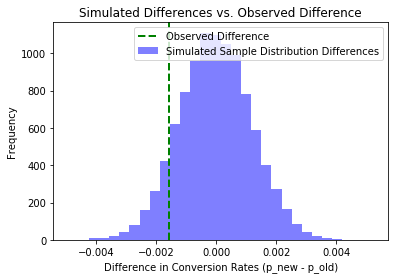

In [27]:
#plot histogram of the simulated sample distribution of differences in conversion rates.
plt.hist(p_diffs,bins=30, alpha=0.5, color='blue', label = 'Simulated Sample Distribution Differences')

#draw vertical dashed line for the observed difference in conversion rate from the actual data
plt.axvline(x=obs_diff, color='green', linestyle='dashed', linewidth=2, label='Observed Difference')

plt.title('Simulated Differences vs. Observed Difference')
plt.xlabel('Difference in Conversion Rates (p_new - p_old)')
plt.ylabel('Frequency')

plt.legend()

plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [28]:
#calculate p-value by finding the proportion of simulated differences that are greater then the observed
p_value = (p_diffs > obs_diff).mean()
print(f"{p_value:.4f}")

0.9062


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

The calculation in part j is referred to as the p-value. Our p-value indicates that there is not strong statistical evidence that suggests the new page is significantly more effective at converting compared to the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [46]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("group == 'control' and converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("group == 'treatment' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("group == 'control'").shape[0]

# number of individuals who received new_page
n_new = df2.query("group == 'treatment'").shape[0]

print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489
17264
145274
145310


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [47]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

The z-score of 1.31 indicates that the observed difference between the conversion rates of the two pages is about 1.31 standard deviations above what we'd expect under the null hypothesis. The high p-value of 0.905, much greater than the Type I error rate of 0.05, indicates that this observed difference is not statistically significant. This is consistent with our earlier findings, suggesting we fail to reject the null hypothesis. While there might be slight variations between this method and our manual calculations, both methods point to the same conclusion: the evidence does not support that the new page has a higher conversion rate than the old page.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression should be used since the data is a binary outcome.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [59]:
#add constant
df2['intercept'] = 1
#create dummy var based on group, 1 = treatment 0 = control
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [60]:
#set dependent var as converted
y = df2['converted']
#set independent variables
X = df2[['intercept', 'ab_page']]
#create logistic regression model
log_model = sm.Logit(y,X)
#fit the model and store
result = log_model.fit()



Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [61]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-10-17 01:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


The p-value for ab_page is ~0.19. The previous p-value was ~0.09. The difference in p-value is due to changing the null and alternative hypothesis that we were testing, and our testing changed from one-sided to two-sided.

In Part II, the null hypothesis was the old page was equal to or better than the new page for conversions, and the alternative hypothesis was the new page was better than the old page for conversions. This is a one-sided test focused on whether the new page leads to a higher conversion rate than the old page.

In Part III, the null hypothesis is that the conversion rate has no relationship to page type, and the alternative hypothesis is that there is a relationship. This test is two-sided, and we are examining if the page type has any impact on the conversion rate (increased or decreased). 

Our current p-value with ab_page is ~0.19, this is greater than the Type I error rate of 0.05. This means we do not have enough evidence to reject the null hypothesis and based on the logistic regression analysis, there is no significant difference for conversion between old and new pages. This matches our Part II hypothesis test, which did not provide enough evidence to determine that the old page was worse than the new page for conversions.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding additional factors into the regression model can increase the model's ability to accurately predict conversion rate as it can capture a wider range of influential factors. Furthermore, relevant covariates can help account for confounding variables. 

These additional factors can have disadvantages if not properly handled. One such risk is multicollinearity; this can reduce the ability to distinguish the effects of each factor and lead to inaccurate models.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [62]:
country_df = pd.read_csv('countries.csv')



In [63]:
#merge df2 and country_df, inner join on user_id
df_merged = df2.merge(country_df, on='user_id', how = 'inner')

df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [64]:
#create dummy variables for country
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [65]:
y = df_merged['converted']
#add UK and US as predictors, CA becomes intercept/baseline
#CA used as baseline to avoid multicollinearity
X = df_merged[['intercept','UK','US']]

country_log_model = sm.Logit(y,X)
country_result = country_log_model.fit()

country_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-10-17 01:59 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

Based on these results, the country does not appear to have a statistically significant impact. Individuals from the UK and the US show a slightly higher conversion rate compared to users from Canada. This is statistically insignificant as their p-values exceed 0.05.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [66]:
#create interaction terms for UK and US based on page to see if impact of page conversion differs based on country
df_merged['UK_page']= df_merged['UK'] * df_merged['ab_page']
df_merged['US_page']= df_merged['US'] * df_merged['ab_page']

y=df_merged['converted']
#add predictors including new interaction terms
X=df_merged[['intercept','ab_page','UK','US','UK_page','US_page']]

interaction_log_mod = sm.Logit(y,X)
interaction_results = interaction_log_mod.fit()

interaction_results.summary2()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-10-17 01:59 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

All predictors' p-values exceed our Type I error rate(0.05). This suggests that these factors are not statistically significant for predicting conversion rate. Since the predictors are insignificant to the conversion rate, we fail to reject the null hypothesis. The page type and user country do not significantly change the conversion rate by themselves or their interaction.

This suggests that implementing the new page may not produce a noticeable benefit in conversion rate over the old page. Other factors outside the user's country and page type might be at play, or the new page doesn't provide a compelling enough reason to convert.

From a business standpoint, it might be more beneficial to look into other avenues to improve conversion rate, such as revising content, improving user experience, or the user interface. Our findings suggest the new page does not improve conversion rate and may be reconsidering its utility to recover its cost and increase the overall return on investment.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0